In [44]:
from matplotlib import pyplot as plt
from superlet import superlet, scale_from_period
from mne.io import read_epochs_fieldtrip
from mne import create_info
import numpy as np
from burst_detection import extract_bursts
from fooof import FOOOF

In [12]:
ch_names = ['L1','L2','L3','L4','R1','R2','R3','R4','F3','Fz','F4','C3','C4','Cz','AA']
sfreq = 512
info = create_info(ch_names, sfreq, ch_types='eeg', verbose=None)
epochs = read_epochs_fieldtrip(
    "resting_ft_EpochedConc_s06_MED_ON.mat", info,
    data_name='resting_ft_EpochedConc', trialinfo_column=6
)
times = epochs.times
trials = epochs.get_data()[:, 11, :]

Not setting metadata
25 matching events found
No baseline correction applied
0 bad epochs dropped


In [16]:
max_freq = 120
foi = np.linspace(1, max_freq, 400)
scales = scale_from_period(1/foi)
tf_trials = []
for trial in trials:
    tf = superlet(
        trial, sfreq, scales, 40, c_1=4, adaptive=True
    )
    tf_trials.append(np.single(np.abs(tf)))
tf_trials = np.array(tf_trials)

In [33]:
search_range = np.where((foi >= 10) & (foi <= 33))[0]
beta_lims = [13, 30]

In [45]:
average_psd = np.average(tf_trials, axis=(2, 0))

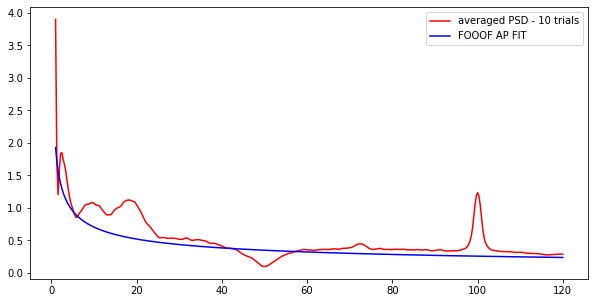

In [47]:
f, ax = plt.subplots(1 , 1, figsize=(10, 5))
ff = FOOOF()
ff.fit(foi, average_psd, [1, 120])
ap = 10 ** ff._ap_fit 
ax.plot(foi, average_psd, c="red", label="averaged PSD - 10 trials")
ax.plot(foi, ap, c="blue", label="FOOOF AP FIT")
ax.legend()

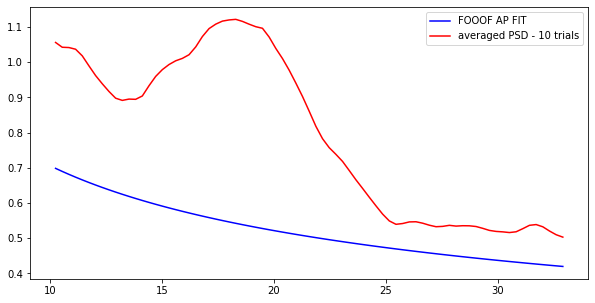

In [71]:
f, ax = plt.subplots(1 , 1, figsize=(10, 5))
ax.plot(foi[search_range], ap[search_range], c="blue", label="FOOOF AP FIT")
ax.plot(foi[search_range], average_psd[search_range], c="red", label="averaged PSD - 10 trials")
ax.legend()

residual_search_power = average_psd[search_range] - ap[search_range]

In [49]:
bursts = extract_bursts(
    trials, tf_trials[:,search_range], times, 
    foi[search_range], beta_lims, 
    ap[search_range].reshape(-1, 1), sfreq
)

In [50]:
bursts.keys()

dict_keys(['trial', 'waveform', 'peak_freq', 'peak_amp_iter', 'peak_amp_base', 'peak_time', 'peak_adjustment', 'fwhm_freq', 'fwhm_time', 'polarity', 'waveform_times'])

Text(0.5, 1.0, 'Burst Duration')

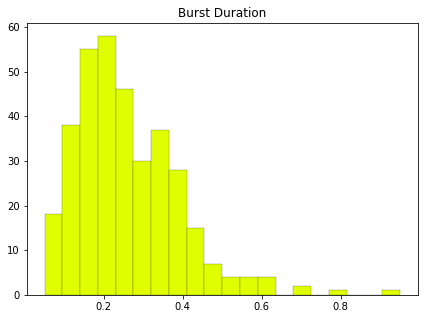

In [115]:
f, ax = plt.subplots(1,1, figsize=(7, 5))
ax.hist(bursts["fwhm_time"], bins=20, color="#DFFF00", edgecolor='black', linewidth=0.2);
ax.set_title("Burst Duration");

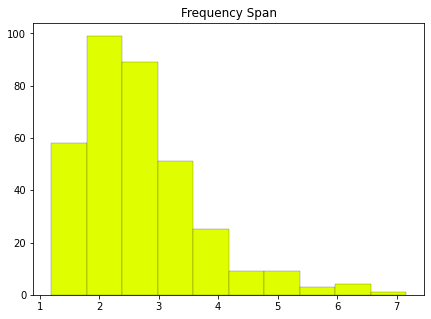

In [116]:
f, ax = plt.subplots(1,1, figsize=(7, 5))
ax.hist(bursts["fwhm_freq"], bins=10, color="#DFFF00", edgecolor='black', linewidth=0.2);
ax.set_title("Frequency Span");

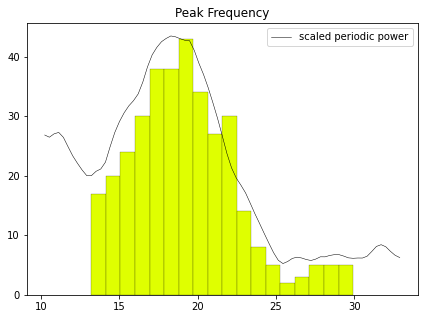

In [118]:
f, ax = plt.subplots(1,1, figsize=(7, 5))
ax.hist(bursts["peak_freq"], bins=18, color="#DFFF00", edgecolor='black', linewidth=0.2)
ax.plot(foi[search_range], residual_search_power*0.75e2, lw=0.5, c="black", label="scaled periodic power")
ax.legend()
ax.set_title("Peak Frequency");

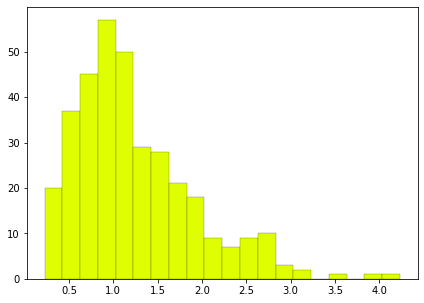

In [84]:
f, ax = plt.subplots(1,1, figsize=(7, 5))
ax.hist(bursts["peak_amp_base"], bins=20, color="#DFFF00", edgecolor='black', linewidth=0.2);

(-20.0, 20.0)

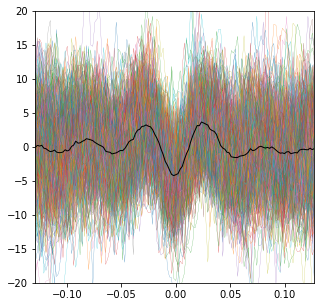

In [99]:
f, ax = plt.subplots(1,1, figsize=(5, 5))
mean_waveform = np.mean(bursts["waveform"], axis=0)
ax.plot(bursts["waveform_times"], bursts["waveform"].T, lw=0.2);
ax.plot(bursts["waveform_times"], mean_waveform, lw=1, c="black");
ax.set_xlim(bursts["waveform_times"][0], bursts["waveform_times"][-1])
ax.set_ylim(-20, 20)

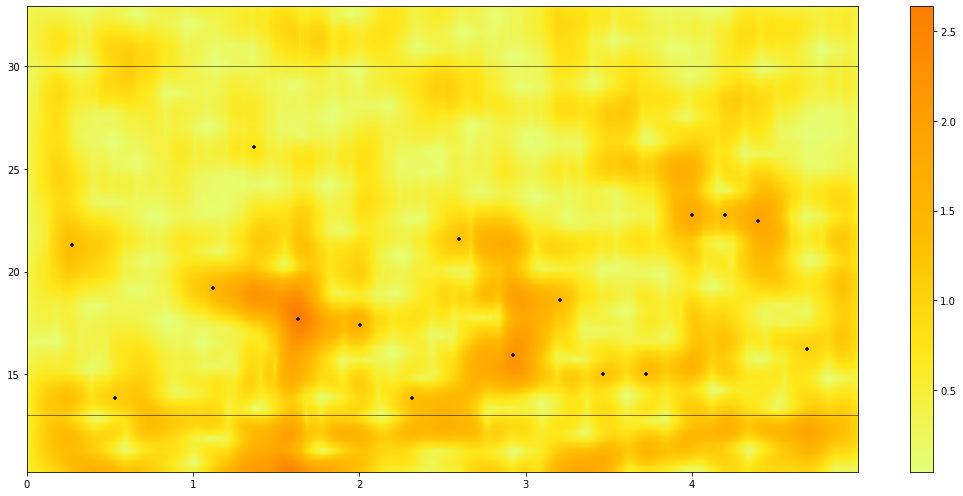

In [114]:
trial = 3
tr_map = bursts["trial"] == trial
f, ax = plt.subplots(1,1, figsize=(15, 7))
spectrum = ax.imshow(tf_trials[trial][search_range], cmap="Wistia", origin="lower", extent=(times[0], times[-1], foi[search_range][0], foi[search_range][-1]), aspect="auto")
ax.scatter(bursts["peak_time"][tr_map], bursts["peak_freq"][tr_map], s=10, marker="+", c="black")
ax.axhline(beta_lims[0], lw=0.5, c="black")
ax.axhline(beta_lims[1], lw=0.5, c="black")
plt.colorbar(spectrum, ax=ax)
plt.tight_layout()